<a href="https://colab.research.google.com/github/GastonRAraujo/Materia-Ap_Maq/blob/master/TP4/Transacciones_fraudulentas_NO_DIM_RED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#imports
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style

import seaborn as sns

#Clasificadores
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#etc
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
transactions_a = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectCCF/data/creditcard_a.csv")

print(transactions_a['Class'].value_counts())

transactions_a.head()

0    187893
1       368
Name: Class, dtype: int64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
transactions_b = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectCCF/data/creditcard_b.csv")

print(transactions_b['Class'].value_counts())

transactions_b.head()

0    96422
1      124
Name: Class, dtype: int64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,127895,0.155432,-0.513165,0.348025,-2.290819,0.412328,0.537240,0.076755,-0.072367,-0.343188,0.104174,-0.321220,0.571147,1.309915,-0.605100,0.625946,-2.554348,0.493100,-0.528454,-1.833773,-0.575761,-0.228727,0.264679,0.154866,-1.067183,-1.192413,0.735726,-0.154075,-0.200072,30.43,0
1,127895,0.144968,0.984625,-0.469259,-0.559418,0.898427,-0.774439,0.966555,-0.079312,0.029686,-0.826361,-0.871466,-0.412111,-0.453984,-0.927580,-0.178107,0.387905,0.352905,-0.118290,-0.185641,0.005702,-0.350727,-0.894781,0.103029,0.458925,-0.419840,0.120432,0.216811,0.082648,9.98,0
2,127895,-0.611349,1.283775,-1.974043,-1.655406,2.984231,3.506069,-0.214317,-0.632051,0.167111,-0.349975,0.142923,-0.022516,-0.474807,-0.768190,0.137271,0.205844,0.470750,-0.364727,-0.459973,-0.159635,1.160112,-1.450777,0.343309,0.560751,-0.335527,0.181544,0.424852,0.145803,1.98,0
3,127895,1.836002,-1.291509,-1.777315,-0.937930,-0.474535,-0.957642,0.010062,-0.324263,-0.882252,0.953930,0.760575,-0.207727,-0.291802,0.467876,-0.363638,1.206906,-0.156158,-1.058576,1.043532,0.353039,0.190313,-0.002319,-0.013476,-0.410082,-0.131701,-0.329364,-0.092481,-0.042942,210.00,0
4,127895,2.013508,0.171357,-2.245188,0.936324,0.243521,-1.389765,0.106378,-0.197682,1.011673,-1.013011,-0.633415,-1.119080,-2.141120,-2.258806,-0.133473,0.386417,2.178073,0.787383,-0.306929,-0.268419,-0.036278,0.138471,-0.027367,-0.273424,0.133993,0.739868,-0.046538,-0.016684,12.31,0


In [4]:
df = pd.concat([transactions_a, transactions_b])

print("Number of NULLS = ", df.isnull().sum().max())

df.head()

Number of NULLS =  0


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

Por razones de privacidad hay features que desconocemos que implican y son reemplazas por Vn


Ahora observemos como esta compuesto:

Number of No Frauds = 284315 
Number of Frauds =       492


No Frauds 99.83 %
Frauds 0.17 %


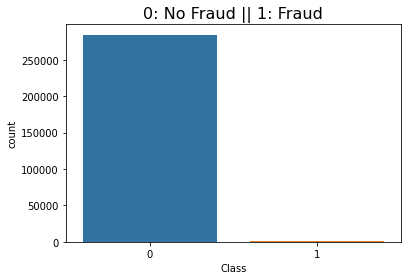

In [6]:
a = df['Class'].value_counts()[0]
b = df['Class'].value_counts()[1]

print('Number of No Frauds = %5d \nNumber of Frauds = %9d' % (a,b))

#Veamoslo con porcentajes

print('\n')
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '%')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '%')


sns.countplot(x = df['Class'])
plt.title('0: No Fraud || 1: Fraud', fontsize=16)
plt.show()

Vemos que el dataframe esta muy desbalanceado

In [7]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Uso un escalado distinto al StandardScaler porque no poseo una distribución normal. En este caso RobustScaler es más apropiado debido a la posible presencia de *outliers.*

Los features Vn se encuentran normalizados, no así "time" y "Amount"

In [8]:
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler()

scaled_amount = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))     #Uso reshape porque da 
scaled_time = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))         #error de dimensiones

df.drop(labels = ['Time','Amount'], axis = 1, inplace=True )

df['scaled_time'] = scaled_time
df['scaled_amount'] = scaled_amount

df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_time,scaled_amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,-0.994983,1.783274
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.994983,-0.269825
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,-0.994972,4.983721
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,-0.994972,1.418291
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.994960,0.670579


In [9]:
X = df.drop('Class', axis=1).to_numpy()
y = df['Class'].to_numpy()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

print(np.count_nonzero(y_train == 0)/len(y_train))
print(np.count_nonzero(y_train == 1)/len(y_train))

0.9982725083038981
0.001727491696101908




---


KNeighborsClassifier

In [11]:
knn = KNeighborsClassifier(n_neighbors=5, p=2)
knn.fit(X_train, y_train)
print("Fitting finished \nStarting prediction...")

Fitting finished 
Starting prediction...


In [12]:
#Predigo usando X_test
y_predicted = knn.predict(X_test)

print("Classification report for classifier {}\n{}\n".format(knn, classification_report(y_test, y_predicted)))

Classification report for classifier KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    142158
           1       0.89      0.71      0.79       246

    accuracy                           1.00    142404
   macro avg       0.95      0.86      0.90    142404
weighted avg       1.00      1.00      1.00    142404




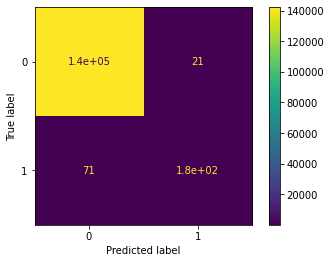

In [13]:
cm = confusion_matrix(y_test,y_predicted)
cm_display = ConfusionMatrixDisplay(cm,display_labels=[0,1]).plot()



---


Support Vector Machine

In [14]:
svc = SVC()
svc.fit(X_train, y_train)
print("Fitting finished \nStarting prediction...")

Fitting finished 
Starting prediction...


In [15]:
#Predigo usando X_test
y_predicted = svc.predict(X_test)

print("Classification report for classifier {}\n{}\n".format(svc, classification_report(y_test, y_predicted)))

Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    142158
           1       0.95      0.63      0.76       246

    accuracy                           1.00    142404
   macro avg       0.97      0.82      0.88    142404
weighted avg       1.00      1.00      1.00    142404




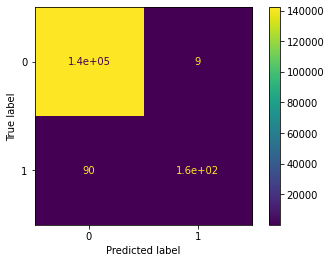

In [16]:
cm = confusion_matrix(y_test,y_predicted)
cm_display = ConfusionMatrixDisplay(cm,display_labels=[0,1]).plot()



---

Random Forest

In [17]:
clf = RandomForestClassifier(n_jobs=-1, random_state=0)

clf.fit(X_train, y_train)
print("Fitting finished \nStarting prediction...")

Fitting finished 
Starting prediction...


In [18]:
#Predigo usando X_test
y_predicted = clf.predict(X_test)

print("Classification report for classifier {}\n{}\n".format(clf, classification_report(y_test, y_predicted)))

Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    142158
           1       0.96      0.76      0.85       246

    accuracy                           1.00    142404
   macro avg       0.98      0.88      0.92    142404
weighted avg       1.00      1.00      1.00    142404




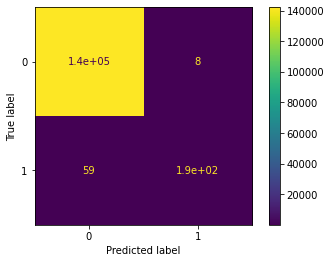

In [19]:
cm = confusion_matrix(y_test,y_predicted)
cm_display = ConfusionMatrixDisplay(cm,display_labels=[0,1]).plot()

Mi dataset de train sigue igual de desbalanceado por lo que tambien voy a probar entrenarlo con partes iguales de ambas clases

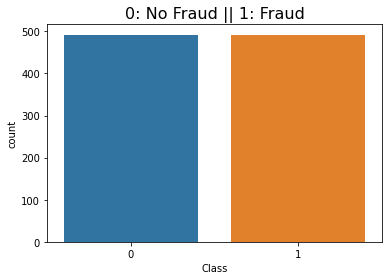

In [20]:
df = df.sample(frac=1)


fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

df2 = pd.concat([fraud_df, non_fraud_df])

sns.countplot(x = df2['Class'])
plt.title('0: No Fraud || 1: Fraud', fontsize=16)
plt.show()

In [21]:
X_balanced = df2.drop('Class', axis=1).to_numpy()
y_balanced = df2['Class'].to_numpy()

print('y.shape = ', y.shape)
print('X.shape = ', X.shape)

X_trainB, X_testB, y_trainB, y_testB = train_test_split(X_balanced, y_balanced, test_size=0.5, random_state=42)

print(np.count_nonzero(y_trainB == 0)/len(y_trainB))
print(np.count_nonzero(y_trainB == 1)/len(y_trainB))

y.shape =  (284807,)
X.shape =  (284807, 30)
0.5142276422764228
0.48577235772357724


Vemos que ahora la relacion es cercana al 50-50

In [22]:
knn2 = KNeighborsClassifier(n_neighbors=5, p=2)
knn2.fit(X_trainB, y_trainB)
print("Fitting finished \nStarting prediction...")

Fitting finished 
Starting prediction...


In [23]:
#Predigo usando X_test
y_predictedB = knn2.predict(X_testB)

print("Classification report for classifier {}\n{}\n".format(knn2, classification_report(y_testB, y_predictedB)))

Classification report for classifier KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       239
           1       0.98      0.86      0.92       253

    accuracy                           0.92       492
   macro avg       0.92      0.92      0.92       492
weighted avg       0.93      0.92      0.92       492




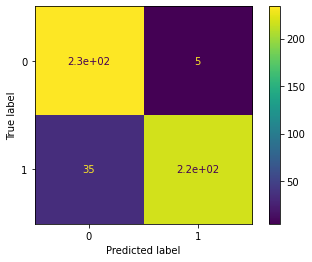

In [24]:
cm2 = confusion_matrix(y_testB,y_predictedB)
cm2_display = ConfusionMatrixDisplay(cm2,display_labels=[0,1]).plot()



---


Support Vector Machine

In [25]:
svc2 = SVC()
svc2.fit(X_trainB, y_trainB)
print("Fitting finished \nStarting prediction...")

Fitting finished 
Starting prediction...


In [26]:
#Predigo usando X_test
y_predictedB = svc2.predict(X_testB)

print("Classification report for classifier {}\n{}\n".format(svc2, classification_report(y_testB, y_predictedB)))

Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       239
           1       0.98      0.84      0.91       253

    accuracy                           0.91       492
   macro avg       0.92      0.91      0.91       492
weighted avg       0.92      0.91      0.91       492




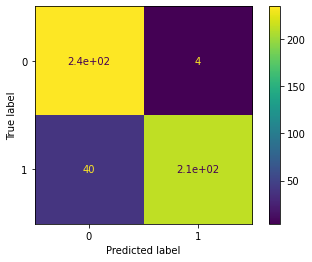

In [27]:
cm = confusion_matrix(y_testB,y_predictedB)
cm_display = ConfusionMatrixDisplay(cm,display_labels=[0,1]).plot()



---

Random Forest

In [28]:
clf2 = RandomForestClassifier(n_jobs=-1, random_state=0)

clf2.fit(X_trainB, y_trainB)
print("Fitting finished \nStarting prediction...")

Fitting finished 
Starting prediction...


In [29]:
#Predigo usando X_test
y_predictedB = clf2.predict(X_testB)

print("Classification report for classifier {}\n{}\n".format(clf2, classification_report(y_testB, y_predictedB)))

Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       239
           1       0.97      0.90      0.93       253

    accuracy                           0.93       492
   macro avg       0.94      0.94      0.93       492
weighted avg       0.94      0.93      0.93       492




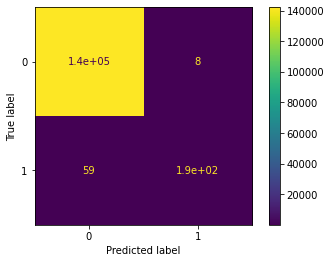

In [30]:
cm = confusion_matrix(y_test,y_predicted)
cm_display = ConfusionMatrixDisplay(cm,display_labels=[0,1]).plot()